In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        (os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision
torch.__version__, torchvision.__version__
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# !nvidia-smi
import os
image_dir = r"/kaggle/input/flickr8k/Images"
text_dir = r"/kaggle/input/flickr8k/captions.txt"
text_dir
data = pd.read_csv(r"/kaggle/input/flickr8k/captions.txt", sep=',')
data.head()

image_arr = data.image.to_numpy()
captions_arr = data.caption.to_numpy()
captions_list = [i.lower().split(" ") for i in captions_arr]
# captions_list

len_caps = max([len(i) for i in captions_list])
print(len_caps)
vocab_list = []
for i in captions_list:
    vocab_list+=i
x = np.unique(vocab_list)
vocabulary = {word:idx for idx, word in enumerate(x, start=1)}
vocabulary["<PAD>"] = 0
a =len(vocabulary)
vocabulary["<SOS>"] = a
vocabulary["<EOS>"] = a + 1
x.shape

voc_inv = {idx: word for word, idx in vocabulary.items()}

def encode(caption, maxLen:int=50):
    caption = caption.split(" ")
    encoded_txt = np.array([vocabulary['<SOS>']] + [vocabulary[word] for word in caption if word in vocabulary])
    x = maxLen - (len(encoded_txt) + 1)
    padding = np.zeros(x)
    eos = np.array([vocabulary["<EOS>"]])
    return np.hstack((encoded_txt, eos, padding))


38


In [45]:
data['encoded'] = data['caption'].apply(encode)
data['length'] = data['caption'].apply(lambda x: len(x.split(" ")))
data['encodedlength'] = data['encoded'].apply(lambda x: len(x))
data.head()

,image,caption,encoded,length,encodedlength
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,"[8919.0, 1486.0, 3918.0, 70.0, 5652.0, 2393.0,...",18,50
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[8919.0, 3275.0, 3335.0, 3993.0, 70.0, 8795.0,...",8,50
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[8919.0, 4441.0, 3275.0, 1591.0, 3993.0, 70.0,...",9,50
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,"[8919.0, 4441.0, 3275.0, 1591.0, 7918.0, 7397....",10,50
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,"[8919.0, 4441.0, 3275.0, 3918.0, 70.0, 5652.0,...",13,50


In [46]:
from PIL import Image
# auto_transform = torchvision.transforms.Compose([
#     torchvision.transforms.Resize((224, 224)),
#     torchvision.transforms.ToTensor(),
#     torchvision.transforms.Normalize([116.42541653, 113.22954264, 102.61758791], [14.8880556, 14.53207325, 16.18046796]),
# ])
from torchvision.models import resnet50, ResNet50_Weights
weights = ResNet50_Weights.DEFAULT
auto_transform = weights.transforms()
class ImageDataLoader(torch.utils.data.DataLoader):
    def __init__(self, df, imgDir = image_dir, transforms=auto_transform ):
        self.transform = transforms
        self.imageDir = imgDir
        self.image = df.image
        self.captions = df.caption
    
    def __getitem__(self, idx):
        path = os.path.join(self.imageDir, self.image[idx])
        image = Image.open(path)
        image = self.transform(image)
        cap = encode(self.captions[idx])
        return image, torch.Tensor(cap)
    
    def __len__(self):
        return len(self.image)

In [47]:
test_train_split = 0.87
idx = int(test_train_split * len(data))
train = data[:idx]
test = data[idx:]
train.head()

,image,caption,encoded,length,encodedlength
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,"[8919.0, 1486.0, 3918.0, 70.0, 5652.0, 2393.0,...",18,50
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[8919.0, 3275.0, 3335.0, 3993.0, 70.0, 8795.0,...",8,50
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,"[8919.0, 4441.0, 3275.0, 1591.0, 3993.0, 70.0,...",9,50
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,"[8919.0, 4441.0, 3275.0, 1591.0, 7918.0, 7397....",10,50
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,"[8919.0, 4441.0, 3275.0, 3918.0, 70.0, 5652.0,...",13,50


In [48]:
trainDataset = ImageDataLoader(df = train)
testDataset = ImageDataLoader(df = test)
Dataset = ImageDataLoader(df = data)
trainDataset

In [49]:
trainDataloader = torch.utils.data.DataLoader(trainDataset, batch_size=32, shuffle=True)
testDataloader = torch.utils.data.DataLoader(testDataset, batch_size=32, shuffle=False)
completeDataloader = torch.utils.data.DataLoader(Dataset, batch_size=32, shuffle=True)

In [50]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.batch_norm = nn.BatchNorm1d(embed_size)
        
    def forward(self, img_tensors):
        features = self.resnet(img_tensors)
        features = features.view(features.shape[0], -1)
        features = self.linear(features)
        features = self.batch_norm(features)
        return features

In [51]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers = 1):
        super(DecoderRNN, self).__init__()
        self.drop_prob = 0.3
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first = True)
        self.dropout = nn.Dropout(self.drop_prob)
        self.linear = nn. Linear(hidden_size, vocab_size)
        
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))

    def init_hidden_eval(self):
        return (torch.zeros(self.num_layers, self.hidden_size, device=device),
                torch.zeros(self.num_layers, self.hidden_size, device=device))
    
    def forward(self, features, captions):
        captions = captions.long()
        captions = captions[:, :-1]
        embeddings = self.embed(captions)
        features = features.unsqueeze(1)
        combined = torch.cat((features, embeddings), dim = 1)
        self.batch_size = combined.shape[0]
        self.hidden = self.init_hidden(self.batch_size)
        hiddens, cells = self.lstm(combined, self.hidden)
        output = self.linear(hiddens)
        return output
    
    def generate(self, features):
        
        caption = []
        hidden = self.init_hidden(features.shape[0])
        features = features.unsqueeze(1)
        x = 0
        while x<51:
            hiddens, hidden = self.lstm(features, hidden)
            outputs = self.linear(hiddens)
            outputs = outputs.squeeze(1)
            
            value, index = torch.max(outputs, dim = 1)
            caption.append(voc_inv[index.item()])
            
            if voc_inv[index.item()] == '<EOS>':
                break
            x+=1
                
            features = self.embed(torch.tensor(index.item(), dtype = torch.long).to(device))
            features = features.unsqueeze(0)
            features = features.unsqueeze(0)
            
        return caption

In [52]:
from torchvision import models
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
batch_size = 32
embed_size = 512
vocab_size = len(vocabulary)
hidden_size = 512
num_epochs = 3

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)

loss_fn = nn.CrossEntropyLoss().to(device)

params = list(encoder.parameters()) + list(decoder.parameters())

optimizer = torch.optim.Adam(params)

cuda


In [53]:
epochs = 1
for epoch in range(epochs):
    trainLoss = 0
    encoder.train()
    decoder.train()
    for batch, (image, caption) in enumerate(trainDataloader):
        image = image.to(device)
        caption = caption.to(device)
        conv_res = encoder(image)
        out = decoder(conv_res, caption)
        out = out.contiguous().view(-1, vocab_size)
        caption = caption.contiguous().view(-1).long()
        loss = loss_fn(out, caption)
        trainLoss+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%250 == 0:
            print(f"Epoch:{epoch+1}| Loss:{loss}")
    trainLoss /= len(trainDataloader.dataset)
    print(f"Epoch:{epoch+1}|Training Loss:{trainLoss}")

Epoch:1| Loss:9.012523651123047
Epoch:1| Loss:0.9823334217071533
Epoch:1| Loss:0.7753387689590454
Epoch:1| Loss:0.8520202040672302
Epoch:1| Loss:0.7062007188796997
Epoch:1|Training Loss:0.027519499313968507


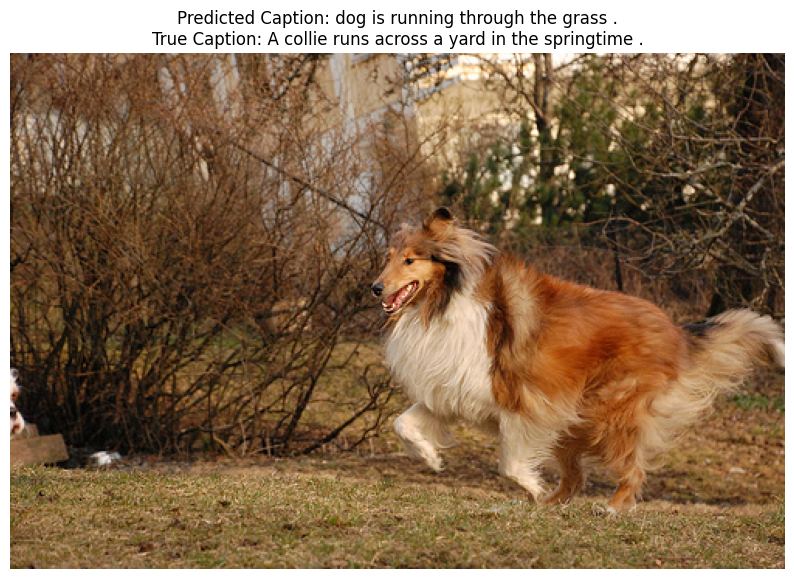

In [96]:
import random
randomIdx = (random.randint(35196, 37254))
x, y = test.image[randomIdx], test.caption[randomIdx]

test_img_file_name = '/kaggle/input/flickr8k/Images/' + x

img = Image.open(test_img_file_name)

img_tensor = auto_transform(img)

img_tensor = img_tensor.unsqueeze(0)
img_tensor = img_tensor.to(device)

encoder.eval()
decoder.eval()

feature = encoder(img_tensor)
# # print(feature.shape)

caption = decoder.generate(feature)
caption = caption[1:-1]
caption = " ".join(caption)
caption

plt.figure(figsize=(10, 7))
plt.title(f"Predicted Caption: {caption}\nTrue Caption: {y}")
plt.imshow(img)
plt.axis(False)
plt.show()